In [2]:
%%capture
# Install required libraries
!pip install yfinance pandas_datareader seaborn statsmodels scikit-learn

In [3]:
!pip install tqdm

In [4]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import warnings
from tqdm import tqdm
import time
from scipy.stats import kurtosis, skew

# Suppress warnings
warnings.filterwarnings('ignore')

In [5]:
# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")  # Fixed style name
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['font.family'] = 'DejaVu Sans'  # Ensures text renders properly


In [6]:
tickers = [
    'ABX.TO', 'AEM.TO', 'AQN.TO', 'ATD.TO', 'BAM.TO', 'BCE.TO', 'BIP-UN.TO',
    'BMO.TO', 'BN.TO', 'BNS.TO', 'CAE.TO', 'CAR-UN.TO', 'CCL-B.TO', 'CCO.TO',
    'CM.TO', 'CNQ.TO', 'CNR.TO', 'CP.TO', 'CSU.TO', 'CTC-A.TO', 'CVE.TO',
    'DOL.TO', 'EMA.TO', 'ENB.TO', 'FM.TO', 'FNV.TO', 'FSV.TO', 'FTS.TO',
    'GIB-A.TO', 'GIL.TO', 'H.TO', 'IFC.TO', 'IMO.TO', 'K.TO', 'L.TO', 'MFC.TO',
    'MG.TO', 'MRU.TO', 'NA.TO', 'NTR.TO', 'OTEX.TO', 'POW.TO', 'PPL.TO',
    'QSR.TO', 'RCI-B.TO', 'RY.TO', 'SAP.TO', 'SHOP.TO', 'SLF.TO', 'SU.TO',
    'T.TO', 'TD.TO', 'TECK-B.TO', 'TOU.TO', 'TRI.TO', 'TRP.TO', 'WCN.TO',
    'WN.TO', 'WPM.TO', 'WSP.TO'
]

In [7]:
sector_classification = {
    'Oil & Gas': ['CNQ.TO', 'CVE.TO', 'ENB.TO', 'IMO.TO', 'PPL.TO', 'SU.TO', 'TRP.TO', 'TOU.TO'],
    'Mineral Commodities': ['ABX.TO', 'AEM.TO', 'CCO.TO', 'FM.TO', 'FNV.TO', 'MG.TO', 'WPM.TO', 'TECK-B.TO'],
    'Technology': ['OTEX.TO', 'CSU.TO', 'K.TO', 'GIB-A.TO', 'SHOP.TO', 'L.TO'],
    'Utilities & Renewables': ['AQN.TO', 'EMA.TO', 'FTS.TO', 'POW.TO', 'NTR.TO'],
    'Financial Services': ['BAM.TO', 'BMO.TO', 'BN.TO', 'BNS.TO', 'CM.TO', 'MFC.TO', 'NA.TO', 'RY.TO', 'SLF.TO', 'TD.TO'],
    'Consumer & Retail': ['ATD.TO', 'CAR-UN.TO', 'CCL-B.TO', 'DOL.TO', 'MRU.TO', 'QSR.TO', 'CTC-A.TO', 'L.TO'],
    'Industrial & Transportation': ['CAE.TO', 'CNR.TO', 'CP.TO', 'FSV.TO', 'WN.TO', 'WSP.TO']
}

In [8]:
start_date = '2015-05-16'
end_date = '2025-05-16'
tsx_index = '^GSPTSE'

In [9]:
# Download data with progress indication
try:
    data = yf.download(tickers, start=start_date, end=end_date, progress=True)['Close']
    tsx = yf.download(tsx_index, start=start_date, end=end_date, progress=False)['Close']

    # Check for missing data
    print("\nData download summary:")
    print(f"Downloaded {len(data)} rows for {len(data.columns)} tickers")
    print(f"TSX data points: {len(tsx)}")

    # Check if data is empty
    if data.empty:
        raise ValueError("No data downloaded for tickers")
    if tsx.empty:
        raise ValueError("No data downloaded for TSX index")
except Exception as e:
    print(f"Error downloading data: {str(e)}")
    # Fallback to empty DataFrames to prevent further errors
    data = pd.DataFrame()
    tsx = pd.Series()

# Handle missing values if data exists
if not data.empty:
    data = data.ffill().bfill()
    returns = data.pct_change().dropna()

    if not tsx.empty:
        tsx = tsx.ffill().bfill()
        tsx_returns = tsx.pct_change().dropna()
    else:
        tsx_returns = pd.Series()

    # Align all returns to the same index
    if not returns.empty and not tsx_returns.empty:
        common_index = returns.index.intersection(tsx_returns.index)
        returns = returns.loc[common_index]
        tsx_returns = tsx_returns.loc[common_index]
        print(f"\nAligned data: {len(returns)} data points")
    else:
        print("\nWarning: Could not align data - one or more return series is empty")
else:
    returns = pd.DataFrame()
    tsx_returns = pd.Series()
    print("\nWarning: No data available for analysis")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  60 of 60 completed



Data download summary:
Downloaded 2509 rows for 60 tickers
TSX data points: 2509

Aligned data: 2508 data points


In [10]:
# Handle missing values
#data = data.ffill().bfill()

In [11]:
data.head()

Ticker,ABX.TO,AEM.TO,AQN.TO,ATD.TO,BAM.TO,BCE.TO,BIP-UN.TO,BMO.TO,BN.TO,BNS.TO,CAE.TO,CAR-UN.TO,CCL-B.TO,CCO.TO,CM.TO,CNQ.TO,CNR.TO,CP.TO,CSU.TO,CTC-A.TO,CVE.TO,DOL.TO,EMA.TO,ENB.TO,FM.TO,FNV.TO,FSV.TO,FTS.TO,GIB-A.TO,GIL.TO,H.TO,IFC.TO,IMO.TO,K.TO,L.TO,MFC.TO,MG.TO,MRU.TO,NA.TO,NTR.TO,OTEX.TO,POW.TO,PPL.TO,QSR.TO,RCI-B.TO,RY.TO,SAP.TO,SHOP.TO,SLF.TO,SU.TO,T.TO,TD.TO,TECK-B.TO,TOU.TO,TRI.TO,TRP.TO,WCN.TO,WN.TO,WPM.TO,WSP.TO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-05-19,12.973830,33.206596,5.825743,22.541016,41.630894,28.985395,17.501144,50.807663,21.971813,22.822842,14.146164,19.451794,26.372810,17.766882,28.721319,11.638107,61.732048,38.926037,475.965088,98.459915,16.618694,22.877699,25.380527,33.727581,17.053244,58.318260,15.401807,26.425089,55.003689,33.381680,15.672757,70.718117,38.349171,2.717021,43.837532,14.803213,47.982018,30.549011,33.113327,53.343384,24.017279,19.087982,22.703678,43.933392,29.855997,54.075172,28.336508,3.125,27.403011,24.381763,12.512422,36.954239,14.092358,25.371037,37.165432,35.581150,43.579296,86.290703,21.096737,36.967358
2015-05-20,12.871808,33.398640,5.849643,22.297989,41.630894,29.023413,17.421335,50.670582,21.764168,22.532619,14.090792,19.381927,26.297108,17.343218,28.483252,11.705967,61.036716,38.776024,488.880737,97.221329,16.740294,23.012949,25.386620,33.491753,16.857794,58.963650,15.401807,26.302097,52.799953,32.913052,15.672757,70.639435,38.743217,2.698908,43.659233,14.681613,47.982018,30.071012,33.046288,53.343384,24.363760,18.810085,22.681118,43.594040,30.017313,53.744331,28.058928,3.125,27.189131,24.570726,12.437223,36.815876,14.056951,25.239918,36.889500,35.259350,43.267292,85.405945,20.973928,36.420937
2015-05-21,12.914318,33.315144,5.873546,22.508297,41.630894,29.099443,17.367065,51.173183,21.947100,22.721430,14.164618,19.249166,26.202019,17.162939,28.826801,11.983583,61.657524,39.502319,483.140533,98.120804,16.918644,22.558870,25.319544,34.369228,15.890303,57.699768,15.401807,26.226923,52.959499,32.636887,15.672757,69.538177,39.799278,2.698908,43.720947,14.784015,49.333031,30.344151,33.529011,53.343384,21.114979,18.960606,23.293892,43.002346,30.438110,54.264244,28.418135,3.125,27.403011,24.867649,12.587615,36.980591,13.844504,25.856163,37.023724,35.705921,43.292255,86.198891,20.991472,36.520271
2015-05-22,12.846299,33.465427,5.813792,22.503628,41.630894,29.197201,17.606499,51.101395,21.813608,22.592054,14.063114,19.256155,26.050598,16.937582,28.775560,11.909549,61.591297,39.840782,483.618866,97.044388,17.291550,22.362436,25.191479,34.001785,16.075979,58.004539,15.401807,26.076582,53.129017,32.954681,15.672757,69.506691,39.744110,2.671738,43.693516,14.668810,50.043728,30.028334,33.301052,53.343384,21.563375,18.995348,23.203362,42.610786,30.529276,54.284485,28.238543,3.494,27.028723,25.043102,12.659797,37.013535,13.755983,25.600494,37.120678,35.476070,43.491924,85.923439,20.894983,36.429203
2015-05-25,12.854804,33.223293,5.831718,22.484932,41.630894,29.376427,17.807625,51.107922,22.026207,22.602552,14.136935,19.214245,26.001291,17.162939,28.757490,11.844771,61.996922,39.782242,485.120850,97.324547,16.983492,22.700579,25.331732,33.294327,15.978252,57.914906,15.401807,26.110752,52.999390,32.786980,15.672757,69.616837,39.223946,2.671738,43.919846,14.681613,49.515972,29.960041,33.307755,53.343384,21.367706,18.977974,22.948753,42.828316,30.578379,54.223724,28.205875,3.726,27.210896,24.935131,12.722963,37.151890,13.658614,25.554586,36.993912,35.318451,43.429520,85.664680,20.675682,36.396088


In [12]:
tsx.head()

Ticker,^GSPTSE
Date,
2015-05-19,15121.000000
2015-05-20,15072.799805
2015-05-21,15203.599609
2015-05-22,15200.799805
2015-05-25,15187.400391


In [13]:
# Calculate daily returns
returns = data.pct_change().dropna()
tsx_returns = tsx.pct_change().dropna()

In [28]:
# Sector analysis function
def analyze_sector(sector_name, sector_tickers):
    valid_tickers = [t for t in sector_tickers if t in returns.columns]
    if not valid_tickers:
        print(f"No valid tickers found for {sector_name} sector")
        return None

    print(f"\n{'='*50}\nAnalyzing {sector_name} Sector ({len(valid_tickers)} companies)\n{'='*50}")

    sector_returns = returns[valid_tickers]

    # Create sector portfolio (equal-weighted)
    sector_portfolio = sector_returns.mean(axis=1)

    # Economic metrics calculation
    metrics = {
        'Annualized Return': sector_portfolio.mean() * 252,
        'Annualized Volatility': sector_portfolio.std() * np.sqrt(252),
        'Sharpe Ratio': (sector_portfolio.mean() / sector_portfolio.std()) * np.sqrt(252),
        'Correlation with TSX': sector_portfolio.corr(tsx_returns),
    }

    # Correct max drawdown calculation
    cumulative_returns = (1 + sector_portfolio).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    metrics['Max Drawdown'] = drawdown.min()

    # Beta calculation with proper alignment
    # Align sector returns with TSX returns
    aligned_data = pd.DataFrame({
        'sector': sector_portfolio,
        'tsx': tsx_returns
    }).dropna()

    if len(aligned_data) < 2:
        print(f"Not enough data to calculate beta for {sector_name}")
        beta = np.nan
    else:
        cov_matrix = np.cov(aligned_data['sector'], aligned_data['tsx'])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    metrics['Market Beta'] = beta

    # Rolling volatility
    rolling_volatility = sector_portfolio.rolling(window=60).std() * np.sqrt(252)

    # Plotting
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle(f'{sector_name} Sector Analysis (2015-2025)', fontsize=16)

    # Cumulative returns
    cumulative_returns.plot(ax=axes[0, 0], title='Cumulative Returns')
    axes[0, 0].axhline(1, color='black', linestyle='--')
    axes[0, 0].set_ylabel('Growth of $1 Investment')

    # Rolling volatility
    rolling_volatility.plot(ax=axes[0, 1], title='60-Day Rolling Annualized Volatility')
    axes[0, 1].axhline(metrics['Annualized Volatility'], color='r', linestyle='--',
                       label=f'Avg Vol: {metrics["Annualized Volatility"]:.2%}')
    axes[0, 1].legend()

    # Correlation heatmap
    corr_matrix = sector_returns.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                ax=axes[1, 0], cbar=False)
    axes[1, 0].set_title('Inter-Company Correlation')


    # Return distribution
    sns.histplot(sector_portfolio, kde=True, ax=axes[1, 1], bins=50)
    axes[1, 1].set_title('Daily Returns Distribution')
    axes[1, 1].axvline(sector_portfolio.mean(), color='r', linestyle='--',
                       label=f'Mean: {sector_portfolio.mean():.4f}')
    axes[1, 1].legend()

    # Drawdown curve
    drawdown.plot(ax=axes[2, 0], title='Portfolio Drawdown', color='darkred')
    axes[2, 0].fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='salmon')
    axes[2, 0].set_ylabel('Drawdown Percentage')

    # Beta visualization - only if we have enough data
    if not np.isnan(beta):
        sns.regplot(x=aligned_data['tsx'], y=aligned_data['sector'],
                    ax=axes[2, 1], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        axes[2, 1].set_title(f'Market Beta: {beta:.2f}')
        axes[2, 1].set_xlabel('TSX Returns')
        axes[2, 1].set_ylabel('Sector Returns')
    else:
        axes[2, 1].axis('off')
        axes[2, 1].text(0.5, 0.5, 'Insufficient data for beta calculation',
                        ha='center', va='center', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print metrics
    print(f"\n{sector_name} Sector Performance Metrics:")
    print(f"• Annualized Return: {metrics['Annualized Return']:.2%}")
    print(f"• Annualized Volatility: {metrics['Annualized Volatility']:.2%}")
    print(f"• Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"• Correlation with TSX: {metrics['Correlation with TSX']:.2f}")
    print(f"• Market Beta: {beta:.2f}")
    print(f"• Max Drawdown: {metrics['Max Drawdown']:.2%}")

    return metrics

The function analyze_sector(sector_name, sector_tickers) does:

For each sector:

Check valid tickers (those that exist in returns DataFrame).

Calculate equal-weighted portfolio returns for the sector.

Calculate financial metrics:

Annualized Return

Annualized Volatility

Sharpe Ratio

Correlation with TSX

Max Drawdown

Beta vs TSX index

Plot several visuals:

Cumulative returns

Rolling volatility (60-day)

Inter-company correlation heatmap within the sector

Daily returns distribution (histogram)

Drawdown curve

Beta regression scatterplot (if enough data)

It’s essentially doing deep risk/return analysis for each sector.



Industry-wide Comparative Analysis


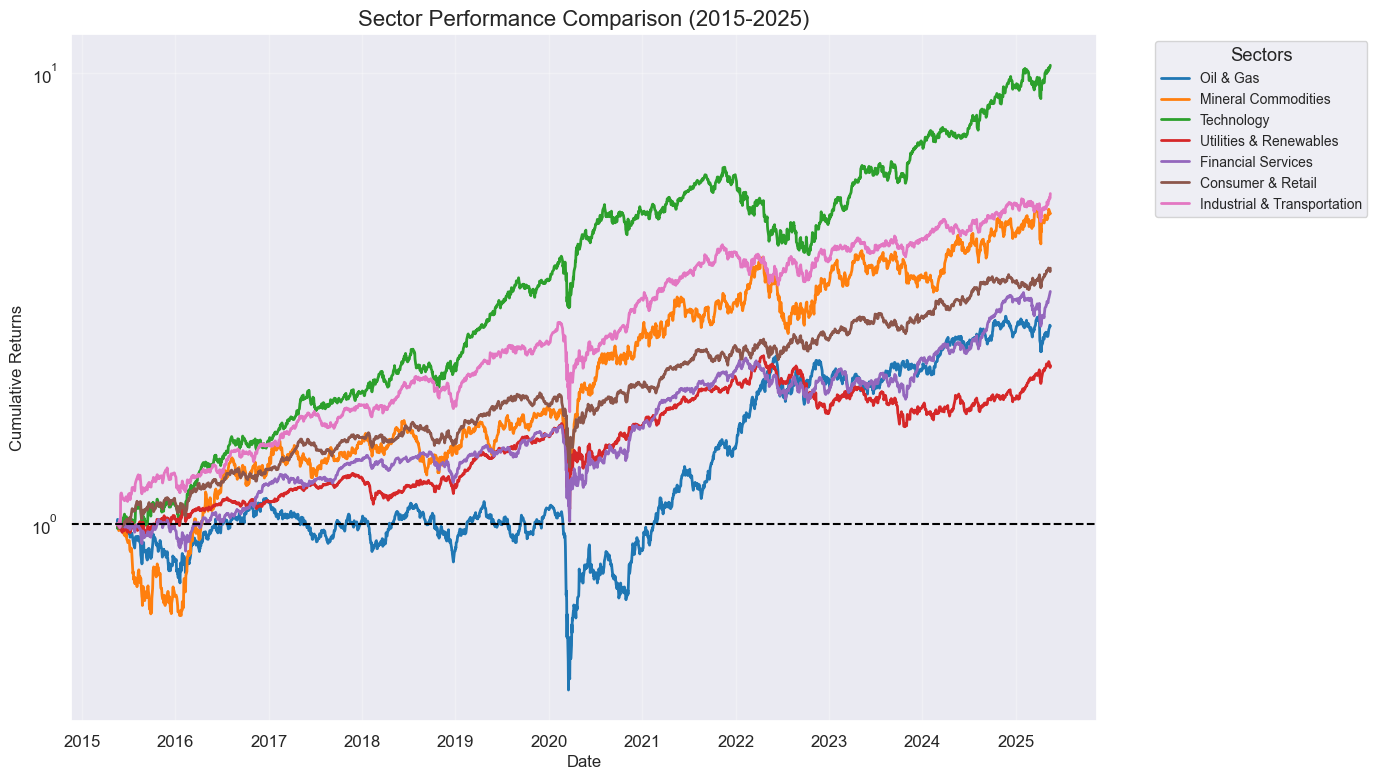

In [25]:
# Analyze each sector
sector_portfolios = {}
for sector, sector_tickers in sector_classification.items():
    valid_tickers = [t for t in sector_tickers if t in returns.columns]
    if valid_tickers:
        sector_series = returns[valid_tickers].mean(axis=1)
        sector_portfolios[sector] = sector_series
    else:
        print(f"⚠️ Skipped {sector} due to no valid tickers.")


# Industry-wide comparative analysis
print("\n\n" + "="*50)
print("Industry-wide Comparative Analysis")
print("="*50)


# Create DataFrame with aligned indices
sector_df = pd.DataFrame(sector_portfolios).dropna()
cumulative_sectors = (1 + sector_df).cumprod()

# Plot comparative cumulative returns
plt.figure(figsize=(14, 8))
for col in cumulative_sectors.columns:
    plt.plot(cumulative_sectors.index, cumulative_sectors[col], lw=2, label=col)

plt.title('Sector Performance Comparison (2015-2025)', fontsize=16)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(1, color='black', linestyle='--')
plt.legend(title='Sectors', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better comparison
plt.tight_layout()
plt.show()

After analyzing each sector individually, then:

Create equal-weight sector portfolios for all sectors.

Combine them into one DataFrame (sector_df).

Plot the cumulative return of all sectors together on the same plot for relative sector performance comparison.

The goal is to visually compare how sectors performed vs each other over time

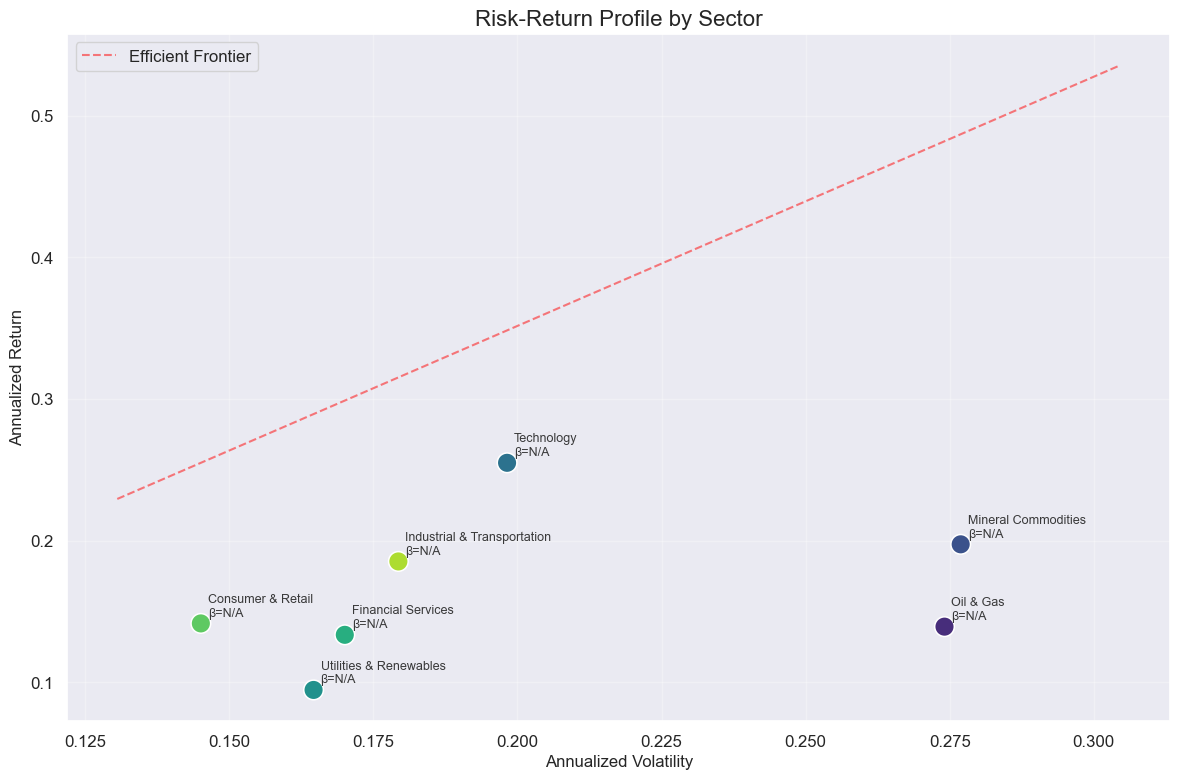

In [29]:
# Risk-return profile
annual_returns = sector_df.mean() * 252
annual_volatility = sector_df.std() * np.sqrt(252)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=annual_volatility, y=annual_returns,
                          hue=annual_returns.index, s=200,
                          palette='viridis', legend=False)

# Add beta values and labels with error handling
for i, sector in enumerate(annual_returns.index):
    # Check if sector exists in metrics
    if sector in sector_metrics and not pd.isna(sector_metrics[sector].get("Market Beta")):
        beta = sector_metrics[sector]["Market Beta"]
        label = f'{sector}\nβ={beta:.2f}'
    else:
        label = f'{sector}\nβ=N/A'

    plt.annotate(label,
                 (annual_volatility[i], annual_returns[i]),
                 textcoords="offset points", xytext=(5,5),
                 ha='left', fontsize=9, alpha=0.9)

plt.title('Risk-Return Profile by Sector', fontsize=16)
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Add efficient frontier line
x = np.linspace(min(annual_volatility)*0.9, max(annual_volatility)*1.1, 100)
y = max(annual_returns) * (x / min(annual_volatility))
plt.plot(x, y, 'r--', alpha=0.5, label='Efficient Frontier')
plt.legend()
plt.tight_layout()
plt.show()

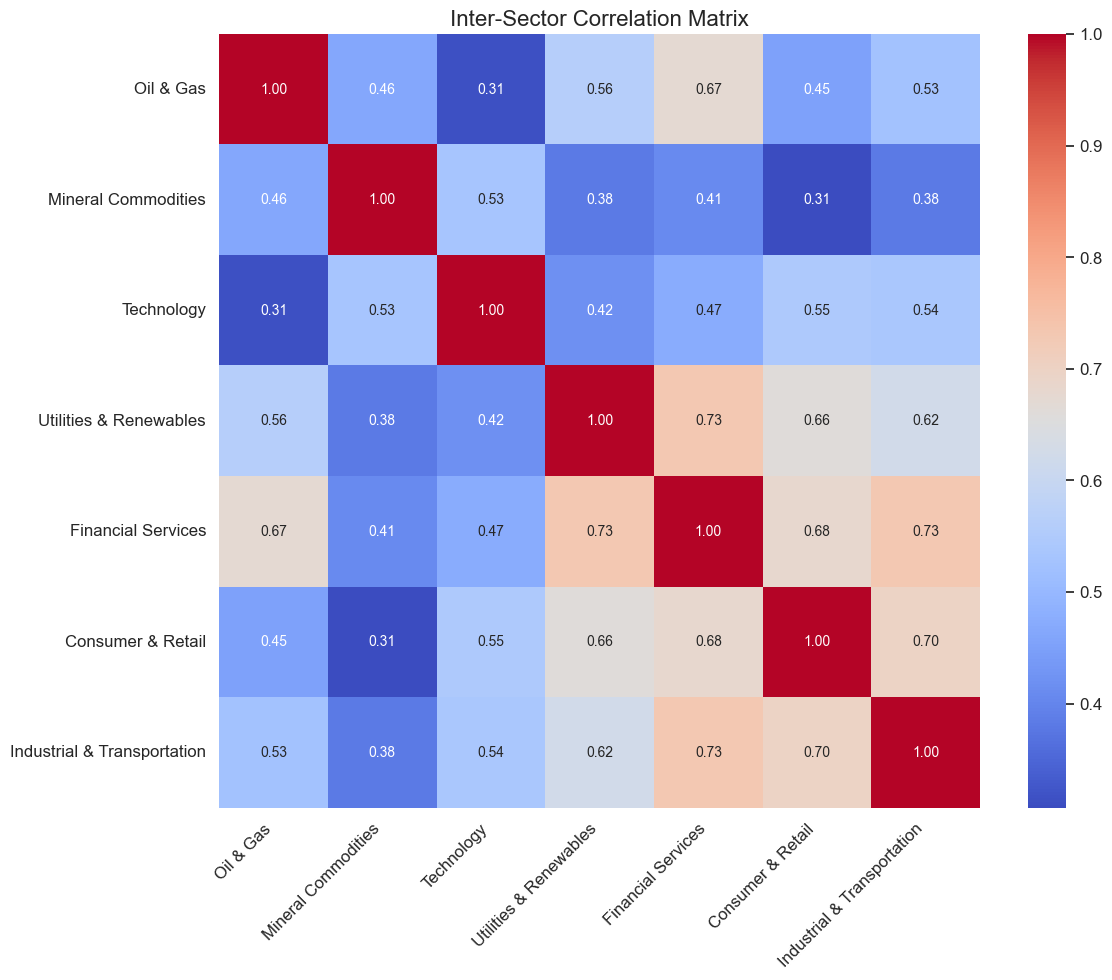



COVID-19 Impact Analysis (2020)


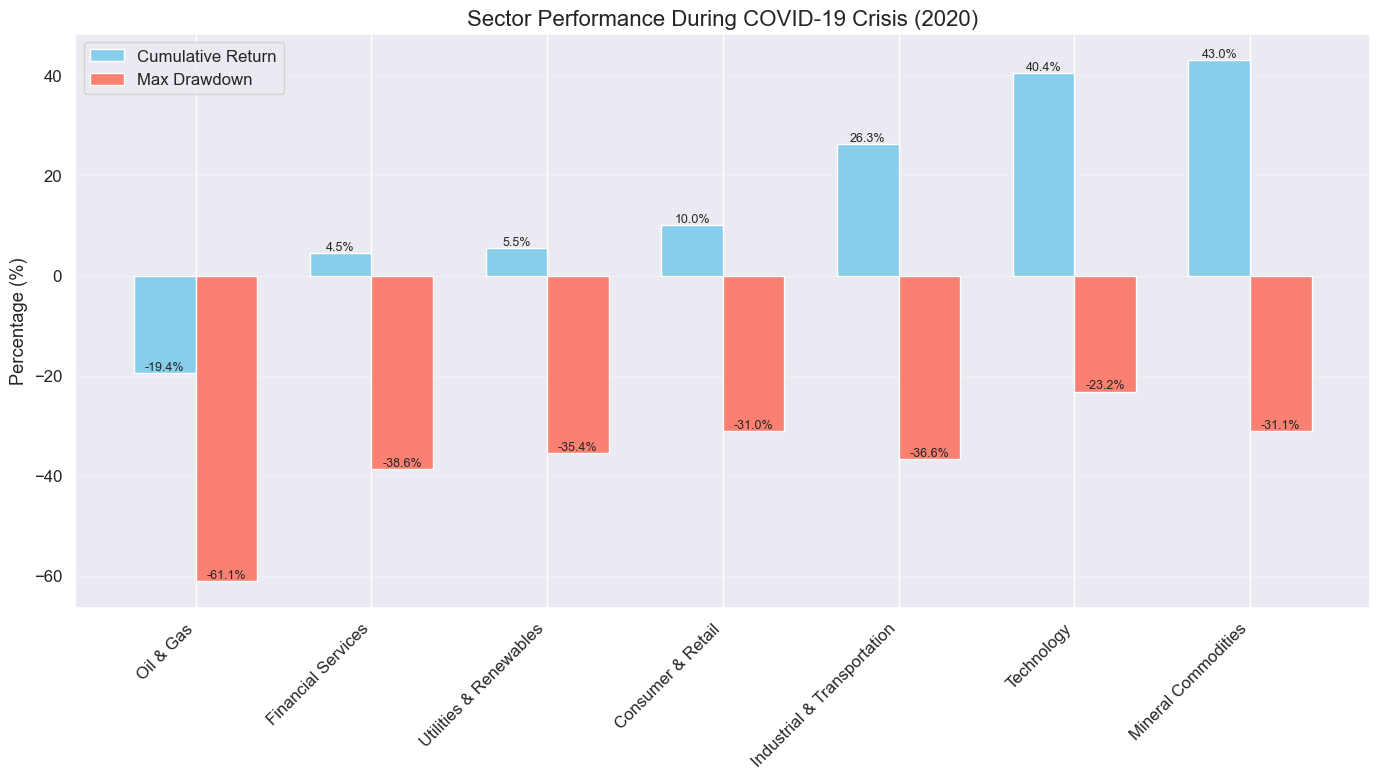



Commodity Price Sensitivity Analysis

Commodity Price Sensitivity Correlations:
           Oil & Gas  Mineral Commodities
Crude Oil       0.24                 0.12
Gold            0.05                 0.47


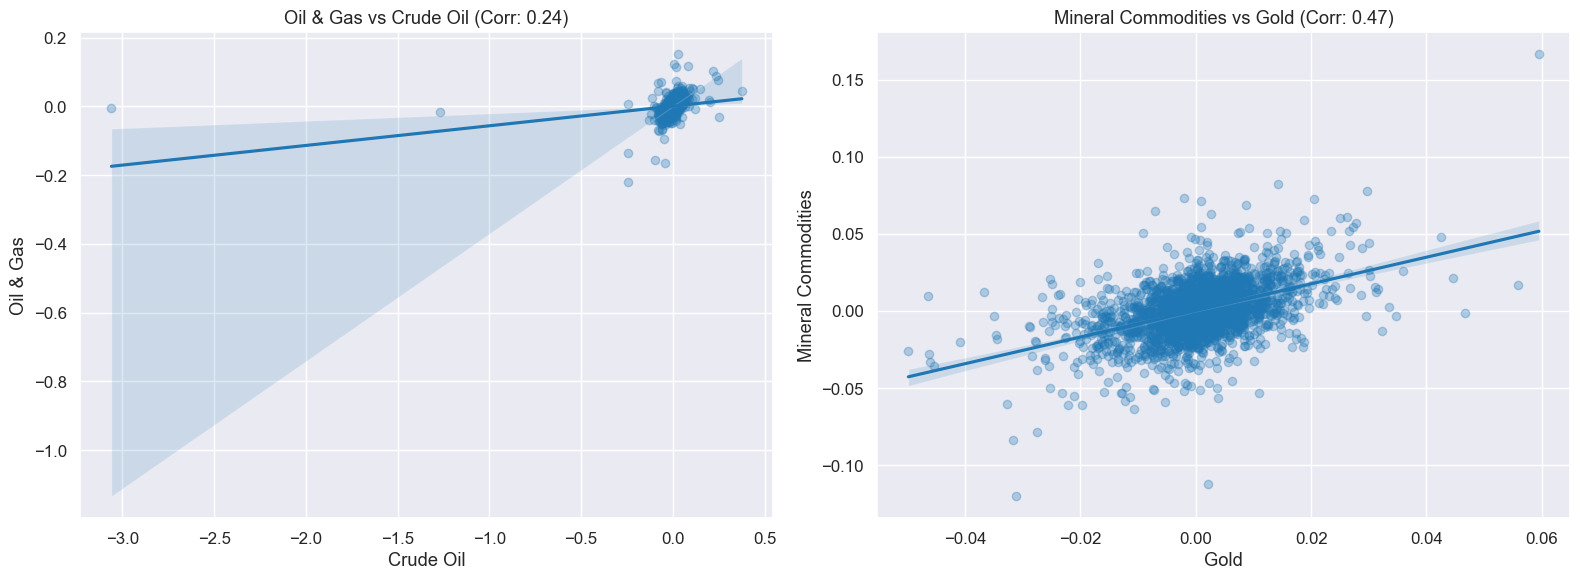

In [30]:
# Correlation analysis
sector_corr = sector_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(sector_corr, annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 10}, cbar=True)
plt.title('Inter-Sector Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Event study analysis (COVID-19 impact)
print("\n\n" + "="*50)
print("COVID-19 Impact Analysis (2020)")
print("="*50)

covid_period = sector_df.loc['2020-01-01':'2020-12-31']

event_metrics = {}
for sector in sector_df.columns:
    sector_ret = covid_period[sector]
    cumulative_return = (1 + sector_ret).prod() - 1
    peak = (1 + sector_ret).cumprod().expanding().max()
    drawdown = ((1 + sector_ret).cumprod() - peak) / peak
    max_drawdown = drawdown.min()

    event_metrics[sector] = {
        'Cumulative Return': cumulative_return,
        'Max Drawdown': max_drawdown
    }

event_df = pd.DataFrame(event_metrics).T
event_df = event_df.sort_values('Cumulative Return')

# Plot COVID-19 impact
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35
ind = np.arange(len(event_df))

p1 = ax.bar(ind - width/2, event_df['Cumulative Return']*100, width,
            color='skyblue', label='Cumulative Return')
p2 = ax.bar(ind + width/2, event_df['Max Drawdown']*100, width,
            color='salmon', label='Max Drawdown')

ax.set_ylabel('Percentage (%)')
ax.set_title('Sector Performance During COVID-19 Crisis (2020)', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(event_df.index, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, axis='y', alpha=0.3)

# Add labels on bars
for i, (ret, dd) in enumerate(zip(event_df['Cumulative Return'], event_df['Max Drawdown'])):
    ax.text(i - width/2, ret*100 + 0.5, f'{ret:.1%}', ha='center', fontsize=9)
    ax.text(i + width/2, dd*100 + 0.5, f'{dd:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Commodity price sensitivity analysis
print("\n\n" + "="*50)
print("Commodity Price Sensitivity Analysis")
print("="*50)

commodity_data = yf.download(['CL=F', 'GC=F'],
                             start=start_date, end=end_date,
                             progress=False)['Close']
commodity_returns = commodity_data.pct_change().dropna()

# Align commodity returns with sector returns
commodity_analysis = pd.DataFrame({
    'Oil & Gas': sector_df['Oil & Gas'],
    'Mineral Commodities': sector_df['Mineral Commodities']
}).join(commodity_returns, how='inner').dropna()

# Rename columns for clarity
commodity_analysis.columns = ['Oil & Gas', 'Mineral Commodities', 'Crude Oil', 'Gold']

# Calculate correlations
commodity_corr = commodity_analysis.corr()
print("\nCommodity Price Sensitivity Correlations:")
print(commodity_corr.iloc[2:, :2].round(2))

# Plot commodity sensitivity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Oil & Gas vs Crude Oil
sns.regplot(x='Crude Oil', y='Oil & Gas', data=commodity_analysis,
            ax=axes[0], scatter_kws={'alpha':0.3})
axes[0].set_title(f'Oil & Gas vs Crude Oil (Corr: {commodity_corr.loc["Crude Oil", "Oil & Gas"]:.2f})')

# Mineral Commodities vs Gold
sns.regplot(x='Gold', y='Mineral Commodities', data=commodity_analysis,
            ax=axes[1], scatter_kws={'alpha':0.3})
axes[1].set_title(f'Mineral Commodities vs Gold (Corr: {commodity_corr.loc["Gold", "Mineral Commodities"]:.2f})')

plt.tight_layout()
plt.show()



Economic Shock Resilience Analysis

Data available from 2015-05-20 to 2025-05-15
Processed Oil Price Crash (2014-2016) from 2015-05-20 to 2016-02-26
Processed COVID-19 (2020) from 2020-02-03 to 2020-04-30
Processed Interest Rate Hike (2022) from 2022-01-04 to 2022-12-30


<Figure size 1400x800 with 0 Axes>

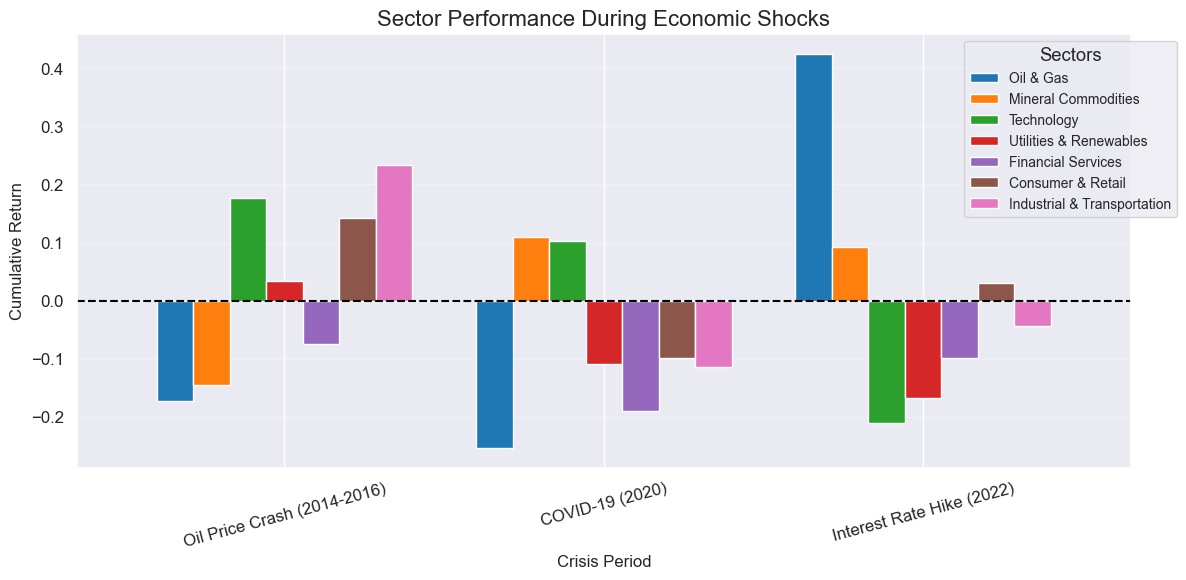


Sector Performance Metrics Summary:
Empty DataFrame
Columns: []
Index: []


In [31]:
# Economic shock resilience analysis
print("\n\n" + "="*50)
print("Economic Shock Resilience Analysis")
print("="*50)
print(f"\nData available from {sector_df.index.min().date()} to {sector_df.index.max().date()}")

# Define crisis periods with flexible date handling
crisis_periods = {
    'Oil Price Crash (2014-2016)': ('2014-06-01', '2016-02-28'),
    'COVID-19 (2020)': ('2020-02-01', '2020-04-30'),
    'Interest Rate Hike (2022)': ('2022-01-01', '2022-12-31')
}

resilience_metrics = pd.DataFrame()

for crisis, (start, end) in crisis_periods.items():
    # Find nearest available dates in the index
    available_start = sector_df.index[sector_df.index >= start][0] if any(sector_df.index >= start) else None
    available_end = sector_df.index[sector_df.index <= end][-1] if any(sector_df.index <= end) else None

    if available_start and available_end and available_start < available_end:
        crisis_returns = sector_df.loc[available_start:available_end]

        if not crisis_returns.empty:
            crisis_perf = (1 + crisis_returns).prod() - 1
            crisis_perf.name = crisis
            resilience_metrics = pd.concat([resilience_metrics, crisis_perf], axis=1)
            print(f"Processed {crisis} from {available_start.date()} to {available_end.date()}")
        else:
            print(f"Skipping {crisis}: No data between {available_start} and {available_end}")
    else:
        print(f"Skipping {crisis}: Date range not available in data")

# Only plot if we have data
if not resilience_metrics.empty:
    plt.figure(figsize=(14, 8))
    resilience_metrics.T.plot(kind='bar', width=0.8)
    plt.title('Sector Performance During Economic Shocks', fontsize=16)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.xlabel('Crisis Period', fontsize=12)
    plt.xticks(rotation=15)
    plt.axhline(0, color='black', linestyle='--')
    plt.legend(title='Sectors', fontsize=10, bbox_to_anchor=(1.05, 1))
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No crisis period data available for plotting")

# Summary table of sector metrics
metrics_summary = pd.DataFrame(sector_metrics).T
print("\nSector Performance Metrics Summary:")
print(metrics_summary)

In [32]:
risk_free_rate = 0.02
# Calculate daily returns
returns = data.pct_change().dropna()

In [33]:
# 1. Calculate daily returns and volatility by sector
sector_returns = {}
sector_metrics = pd.DataFrame()

for sector, sector_tickers in sector_classification.items():
    # Get valid tickers that exist in our data
    valid_tickers = [t for t in sector_tickers if t in returns.columns]

    if valid_tickers:
        sector_ret = returns[valid_tickers].mean(axis=1)
        sector_returns[sector] = sector_ret

        # Calculate metrics
        annual_return = sector_ret.mean() * 252
        annual_volatility = sector_ret.std() * np.sqrt(252)
        sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

        # Calculate Treynor ratio (needs beta)
        cov_matrix = np.cov(sector_ret, returns.mean(axis=1))
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        treynor_ratio = (annual_return - risk_free_rate) / beta

        # Skewness and Kurtosis
        skewness = skew(sector_ret)
        kurt = kurtosis(sector_ret, fisher=False)  # Fisher=False gives Pearson's definition

        # Add to metrics dataframe
        sector_metrics = pd.concat([
            sector_metrics,
            pd.DataFrame({
                'Sector': [sector],
                'Annual Return': [annual_return],
                'Annual Volatility': [annual_volatility],
                'Sharpe Ratio': [sharpe_ratio],
                'Treynor Ratio': [treynor_ratio],
                'Skewness': [skewness],
                'Kurtosis': [kurt],
                'Beta': [beta]
            })
        ], ignore_index=True)

# Print sector metrics
print("\nSector Performance Metrics:")
print(sector_metrics)



Sector Performance Metrics:
                        Sector  Annual Return  Annual Volatility  \
0                    Oil & Gas       0.139389           0.274103   
1          Mineral Commodities       0.197478           0.276912   
2                   Technology       0.254981           0.198190   
3       Utilities & Renewables       0.094739           0.164611   
4           Financial Services       0.133627           0.170030   
5            Consumer & Retail       0.141666           0.145050   
6  Industrial & Transportation       0.185396           0.179328   

   Sharpe Ratio  Treynor Ratio  Skewness   Kurtosis      Beta  
0      0.435563       0.083175 -0.959529  27.486488  1.435389  
1      0.640917       0.139943  0.092640   9.360765  1.268218  
2      1.185636       0.258860 -0.175483   8.079417  0.907753  
3      0.454033       0.085585 -0.421121  39.830902  0.873271  
4      0.668280       0.114411  0.073625  40.441771  0.993152  
5      0.838792       0.162362 -0.458847  

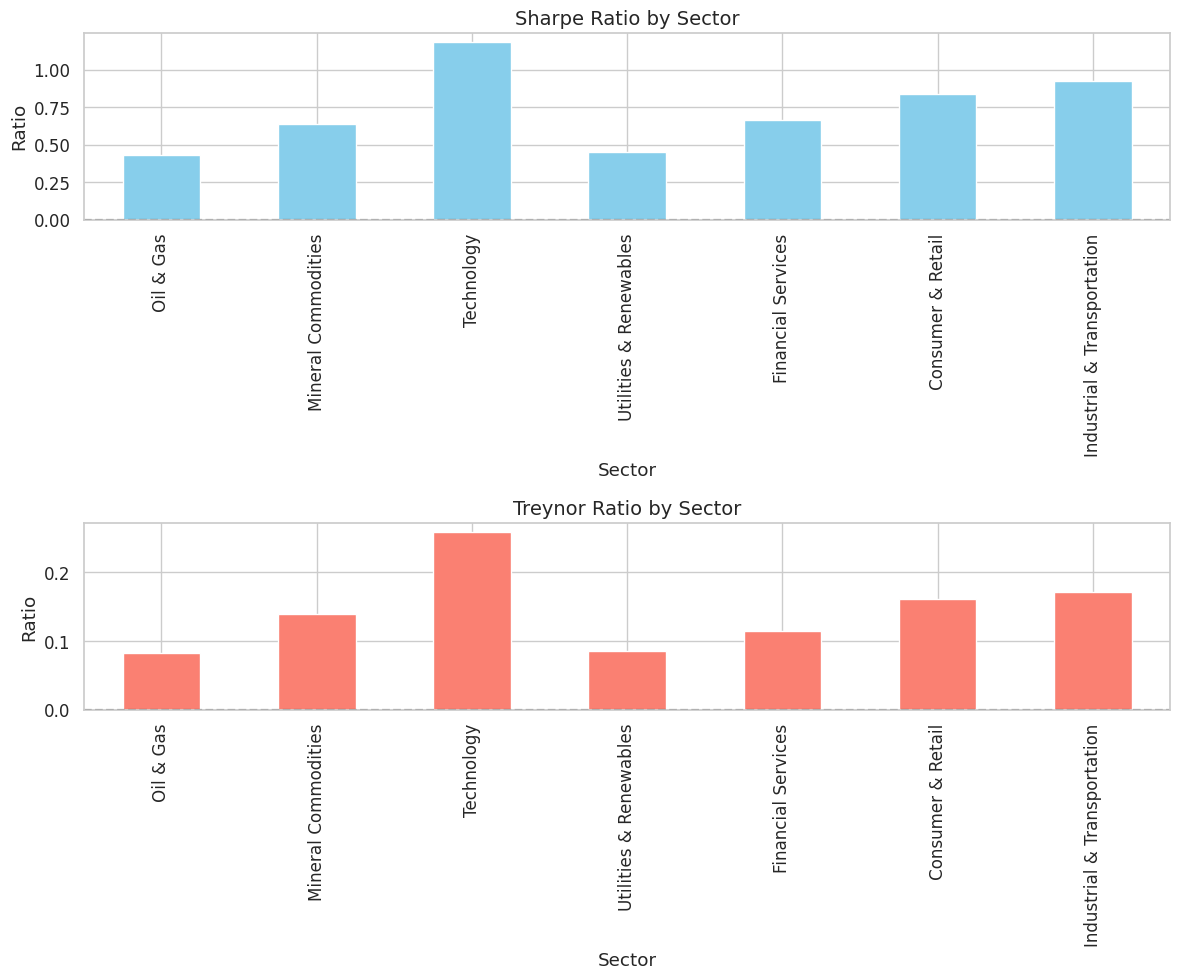

In [66]:
# 2. Visualize Sharpe and Treynor ratios
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sector_metrics.set_index('Sector')['Sharpe Ratio'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Sharpe Ratio by Sector', fontsize=14)
ax[0].axhline(0, color='black', linestyle='--')
ax[0].set_ylabel('Ratio')

sector_metrics.set_index('Sector')['Treynor Ratio'].plot(kind='bar', ax=ax[1], color='salmon')
ax[1].set_title('Treynor Ratio by Sector', fontsize=14)
ax[1].axhline(0, color='black', linestyle='--')
ax[1].set_ylabel('Ratio')

plt.tight_layout()
plt.show()


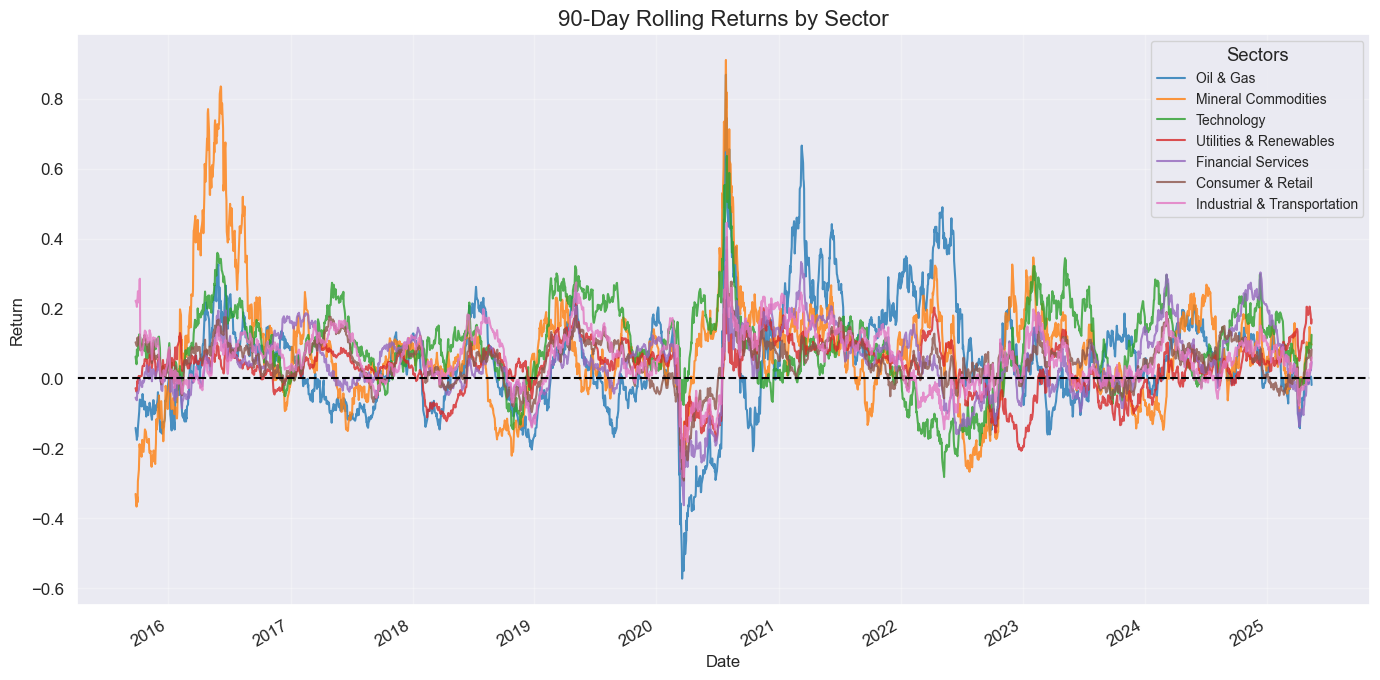

In [34]:
# 3. Rolling returns plot (90-day)
plt.figure(figsize=(14, 7))
for sector, rets in sector_returns.items():
    rolling_returns = (1 + rets).rolling(window=90).apply(np.prod, raw=True) - 1
    rolling_returns.plot(label=sector, alpha=0.8)

plt.title('90-Day Rolling Returns by Sector', fontsize=16)
plt.ylabel('Return', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Sectors', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

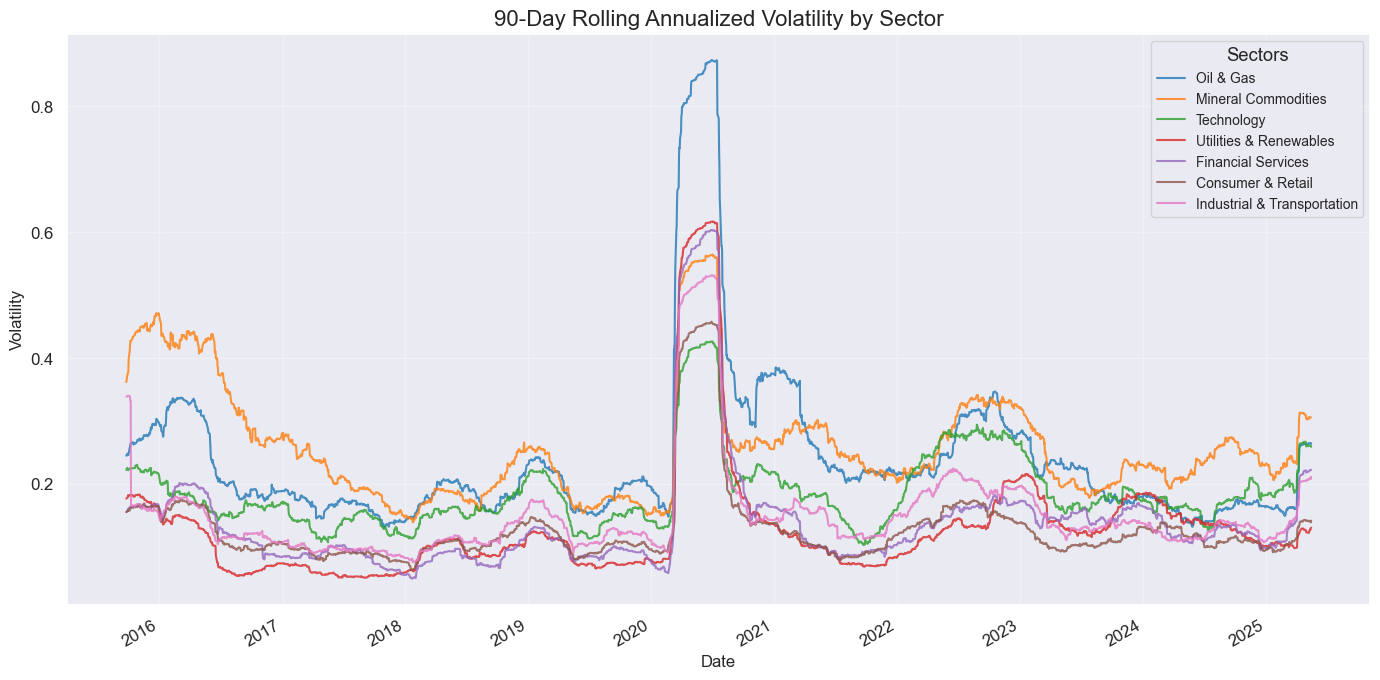

In [35]:
# 4. Rolling volatility plot (90-day)
plt.figure(figsize=(14, 7))
for sector, rets in sector_returns.items():
    rolling_volatility = rets.rolling(window=90).std() * np.sqrt(252)
    rolling_volatility.plot(label=sector, alpha=0.8)

plt.title('90-Day Rolling Annualized Volatility by Sector', fontsize=16)
plt.ylabel('Volatility', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(title='Sectors', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

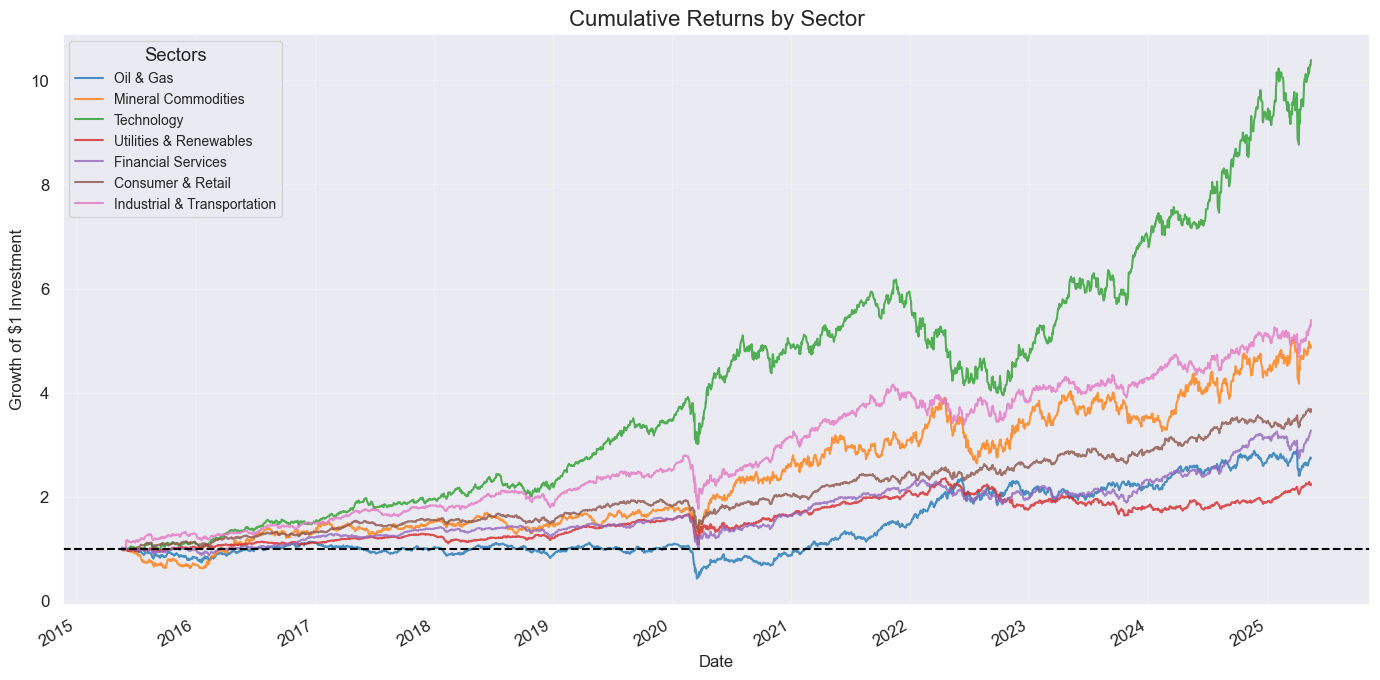

In [36]:
# 5. Cumulative return plot
plt.figure(figsize=(14, 7))
for sector, rets in sector_returns.items():
    cumulative_returns = (1 + rets).cumprod()
    cumulative_returns.plot(label=sector, alpha=0.8)

plt.title('Cumulative Returns by Sector', fontsize=16)
plt.ylabel('Growth of $1 Investment', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(1, color='black', linestyle='--')
plt.legend(title='Sectors', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

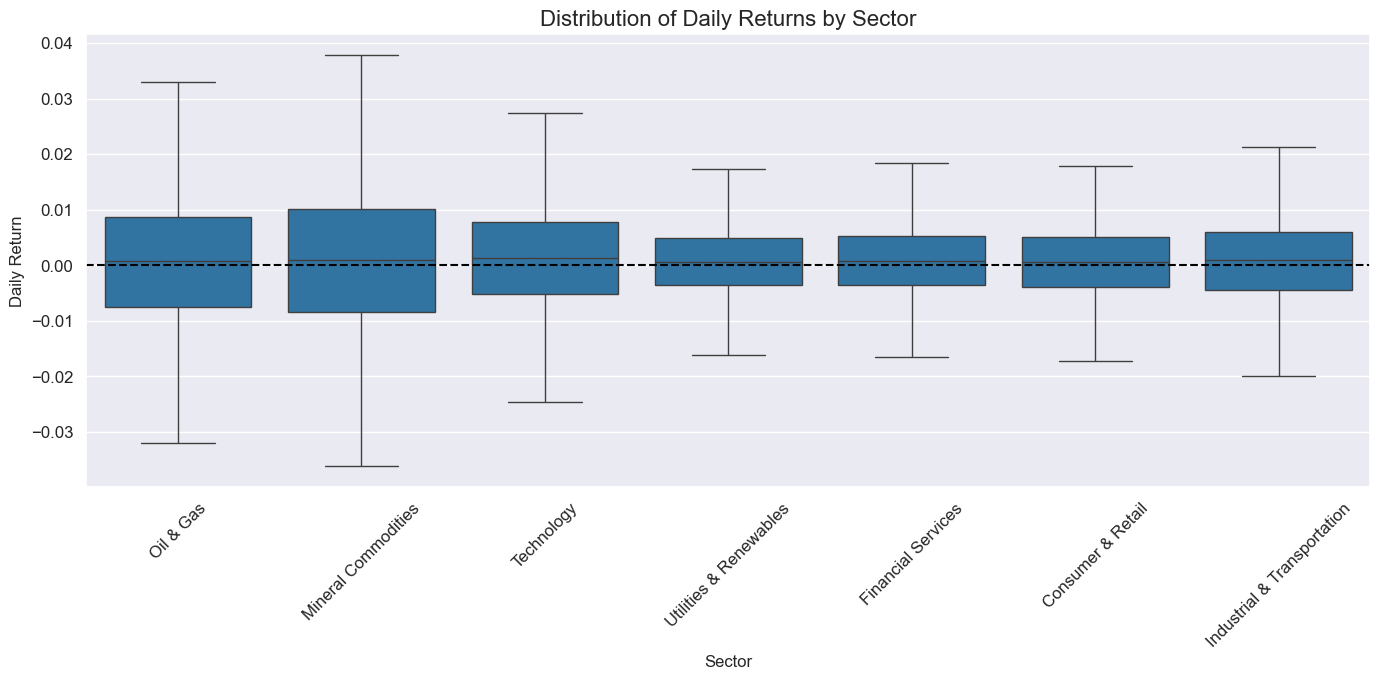

In [37]:
# 6. Boxplot of returns by sector
plt.figure(figsize=(14, 7))
sector_df = pd.DataFrame(sector_returns)
sector_df = sector_df.melt(var_name='Sector', value_name='Daily Return')

sns.boxplot(x='Sector', y='Daily Return', data=sector_df, showfliers=False)
plt.title('Distribution of Daily Returns by Sector', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Daily Return', fontsize=12)
plt.xlabel('Sector', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()



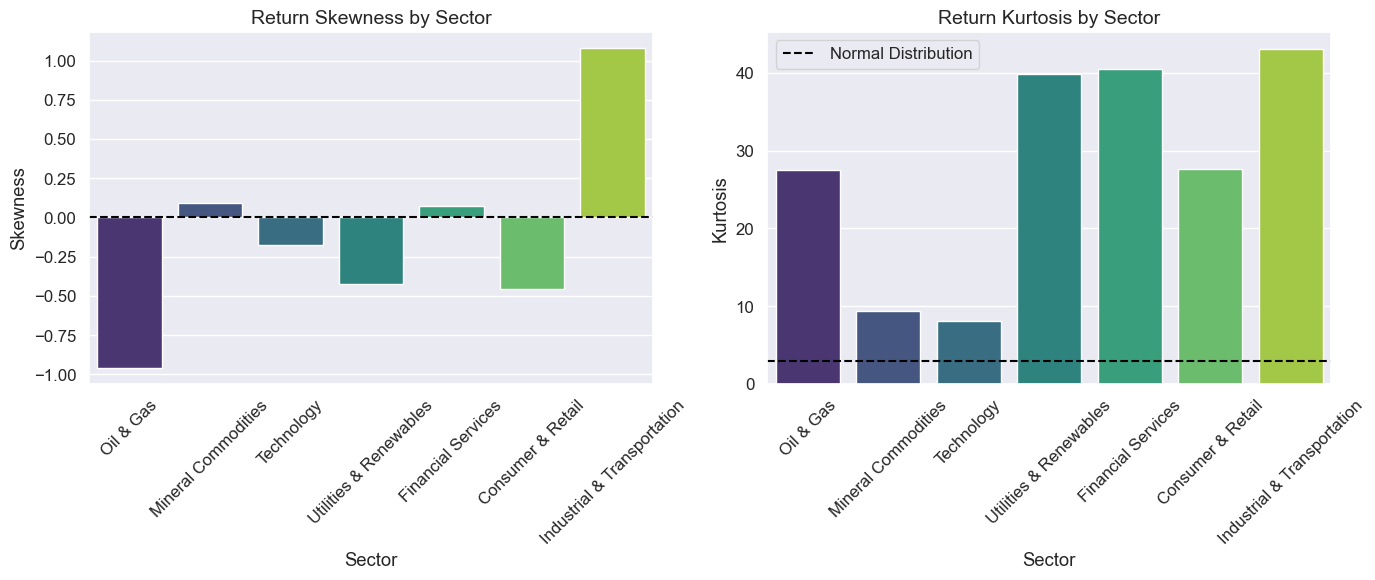

In [38]:
# 7. Skewness and Kurtosis visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Sector', y='Skewness', data=sector_metrics, ax=ax[0], palette='viridis')
ax[0].set_title('Return Skewness by Sector', fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].axhline(0, color='black', linestyle='--')

sns.barplot(x='Sector', y='Kurtosis', data=sector_metrics, ax=ax[1], palette='viridis')
ax[1].set_title('Return Kurtosis by Sector', fontsize=14)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].axhline(3, color='black', linestyle='--', label='Normal Distribution')
ax[1].legend()

plt.tight_layout()
plt.show()


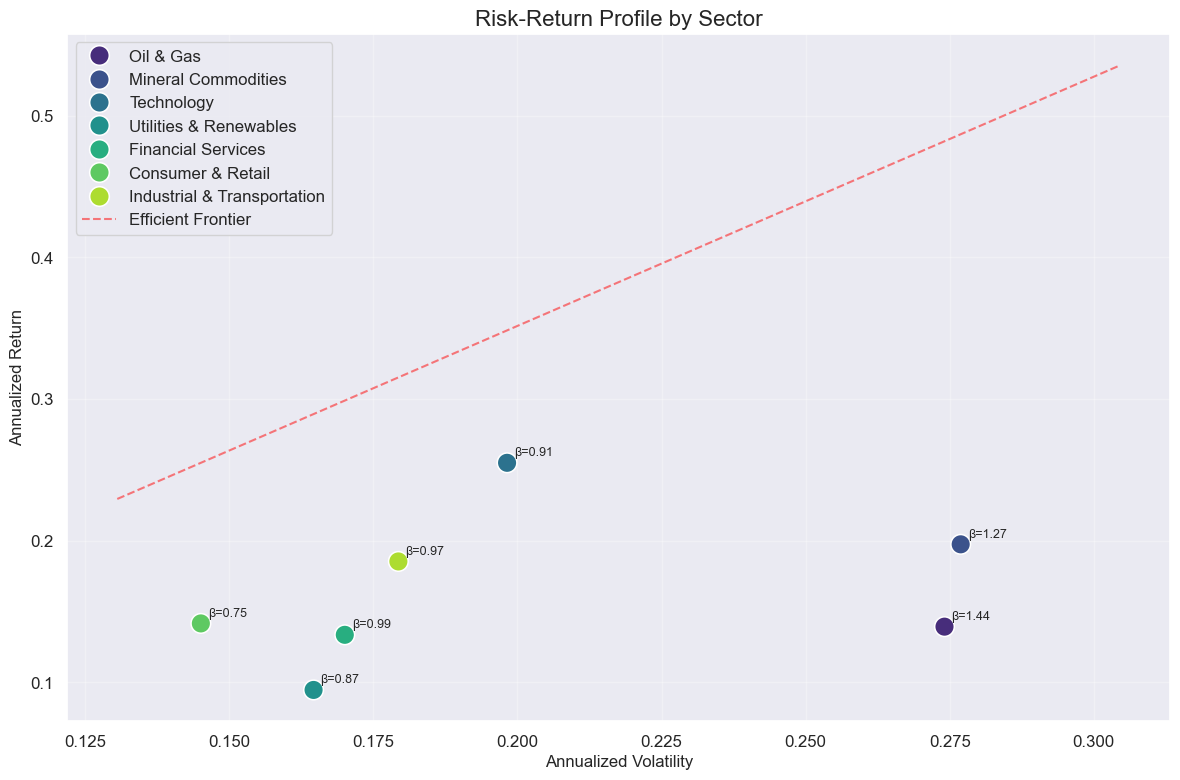


Detailed Sector Performance Metrics:
                        Sector  Annual Return  Annual Volatility  \
0                    Oil & Gas         0.1394             0.2741   
1          Mineral Commodities         0.1975             0.2769   
2                   Technology         0.2550             0.1982   
3       Utilities & Renewables         0.0947             0.1646   
4           Financial Services         0.1336             0.1700   
5            Consumer & Retail         0.1417             0.1450   
6  Industrial & Transportation         0.1854             0.1793   

   Sharpe Ratio  Treynor Ratio  Skewness  Kurtosis    Beta  
0        0.4356         0.0832   -0.9595   27.4865  1.4354  
1        0.6409         0.1399    0.0926    9.3608  1.2682  
2        1.1856         0.2589   -0.1755    8.0794  0.9078  
3        0.4540         0.0856   -0.4211   39.8309  0.8733  
4        0.6683         0.1144    0.0736   40.4418  0.9932  
5        0.8388         0.1624   -0.4588   27.6837 

In [39]:
# Additional: Risk-return scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=sector_metrics, x='Annual Volatility', y='Annual Return',
                hue='Sector', s=200, palette='viridis')

# Add annotations
for i, row in sector_metrics.iterrows():
    plt.annotate(f"β={row['Beta']:.2f}",
                 (row['Annual Volatility'], row['Annual Return']),
                 textcoords="offset points", xytext=(5,5),
                 ha='left', fontsize=9)

plt.title('Risk-Return Profile by Sector', fontsize=16)
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Add efficient frontier
x = np.linspace(sector_metrics['Annual Volatility'].min()*0.9,
                sector_metrics['Annual Volatility'].max()*1.1, 100)
y = sector_metrics['Annual Return'].max() * (x / sector_metrics['Annual Volatility'].min())
plt.plot(x, y, 'r--', alpha=0.5, label='Efficient Frontier')
plt.legend()
plt.tight_layout()
plt.show()

# Print full metrics table
print("\nDetailed Sector Performance Metrics:")
print(sector_metrics.round(4))

In [40]:
# Ensure sector_df only contains numeric returns
sector_df = pd.DataFrame(sector_portfolios)
sector_df = sector_df.dropna()
sector_df = sector_df.select_dtypes(include=[np.number])  # ← This is the fix

# Compute rolling 6-month correlation matrix (approx. 126 trading days)
corr_rolling = sector_df.rolling(window=126).corr().dropna()

# Animate correlation matrix
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(12, 10))
dates = corr_rolling.index.get_level_values(0).unique()

def update(date):
    ax.clear()
    matrix = corr_rolling.loc[date]
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='coolwarm',
                vmin=-1, vmax=1, ax=ax, cbar=False)
    ax.set_title(f'Sector Correlations: {date.date()}', fontsize=16)

anim = FuncAnimation(fig, update, frames=dates[::10], interval=200)
plt.close()
anim.save('sector_correlations.gif', writer='pillow', fps=3)
print("Correlation animation saved as sector_correlations.gif")

Correlation animation saved as sector_correlations.gif


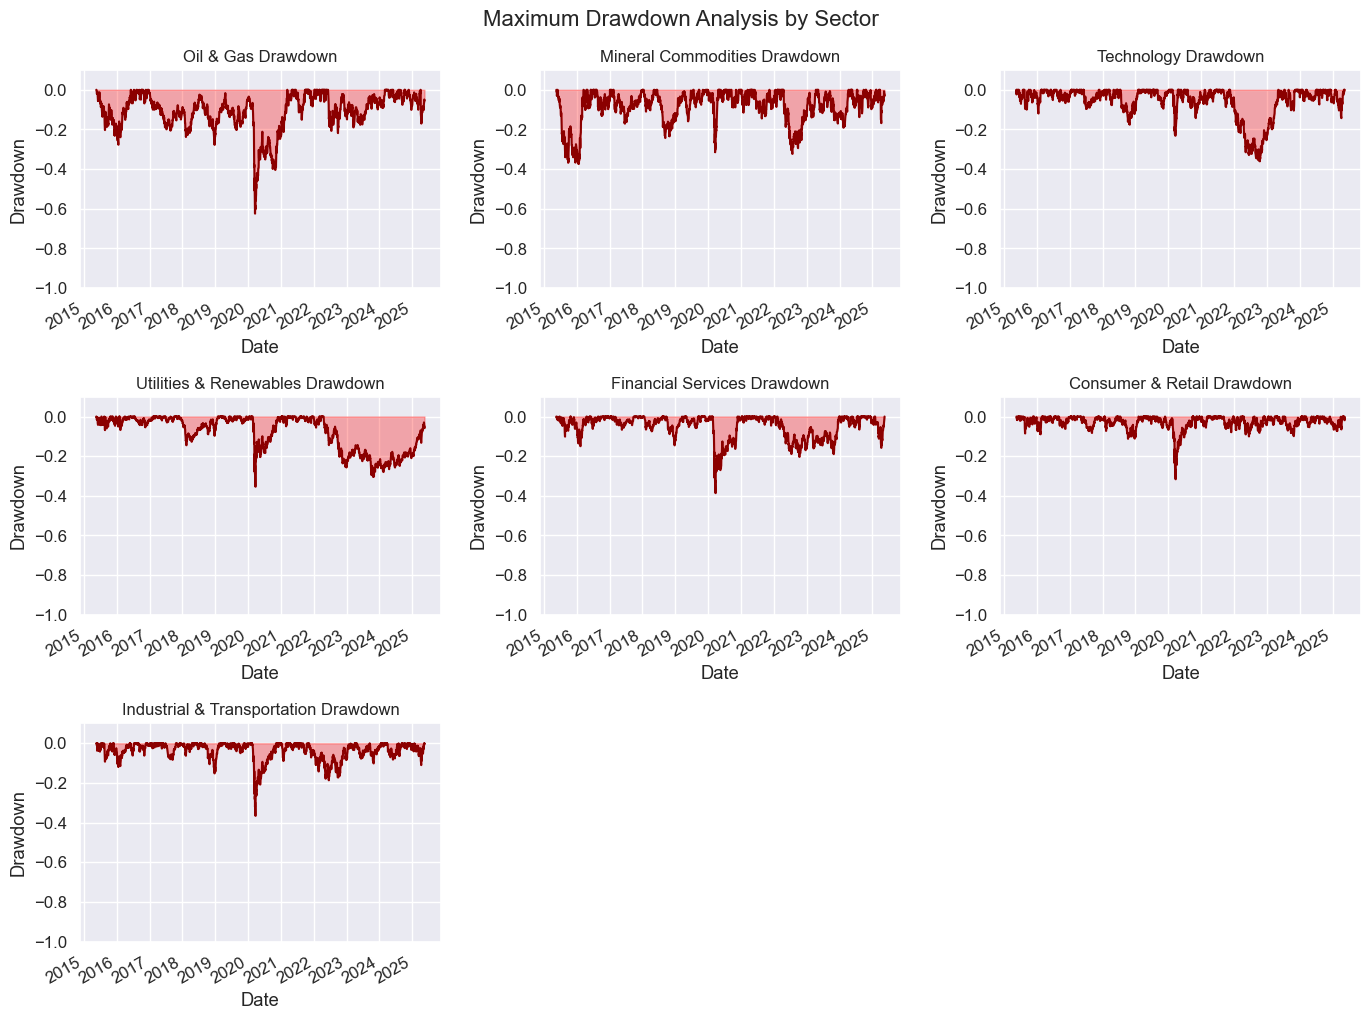

In [41]:
# Visualize maximun drawdowns and recovery periods
plt.figure(figsize=(14, 10))
for i, sector in enumerate(sector_returns):
    cumulative = (1 + sector_returns[sector]).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak

    plt.subplot(3, 3, i+1)
    drawdown.plot(color='darkred')
    plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
    plt.title(f'{sector} Drawdown', fontsize=12)
    plt.ylabel('Drawdown')
    plt.ylim(-1, 0.1)

plt.tight_layout()
plt.suptitle('Maximum Drawdown Analysis by Sector', fontsize=16, y=1.02)
plt.show()

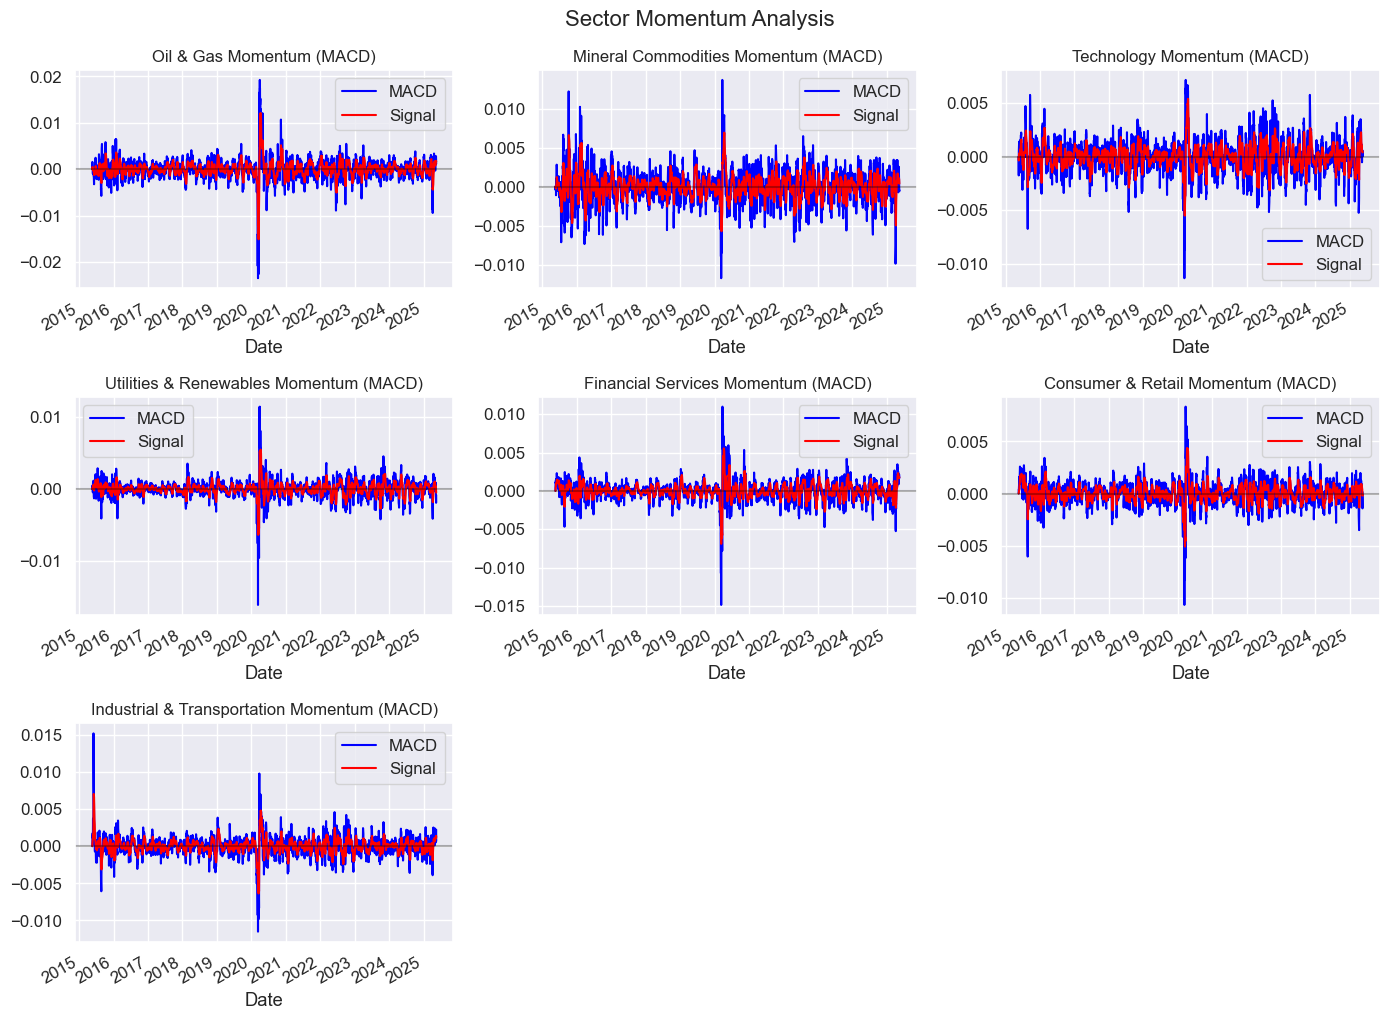

In [42]:
# Visualize momentum using MACD (Moving Average Convergence Divergence)
plt.figure(figsize=(14, 10))
for i, sector in enumerate(sector_returns):
    rets = sector_returns[sector]

    # Calculate MACD
    ema12 = rets.ewm(span=12, adjust=False).mean()
    ema26 = rets.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()

    plt.subplot(3, 3, i+1)
    macd.plot(label='MACD', color='blue')
    signal.plot(label='Signal', color='red')
    plt.title(f'{sector} Momentum (MACD)', fontsize=12)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.suptitle('Sector Momentum Analysis', fontsize=16, y=1.02)
plt.show()

In [43]:
# Calculate relative strength vs TSX
# Show which sectors are leading the market over time
relative_strength = pd.DataFrame()

for sector, tickers in sector_classification.items():
    valid_tickers = [t for t in tickers if t in returns.columns]
    if not valid_tickers:
        continue

    # Equal-weighted sector return
    sector_series = returns[valid_tickers].mean(axis=1)

    cumulative_sector = (1 + sector_series).cumprod()
    cumulative_tsx = (1 + tsx_returns).cumprod()

    # Align index and compute relative strength
    aligned = pd.concat([cumulative_sector, cumulative_tsx], axis=1).dropna()
    relative_strength[sector] = aligned.iloc[:, 0] / aligned.iloc[:, 1]

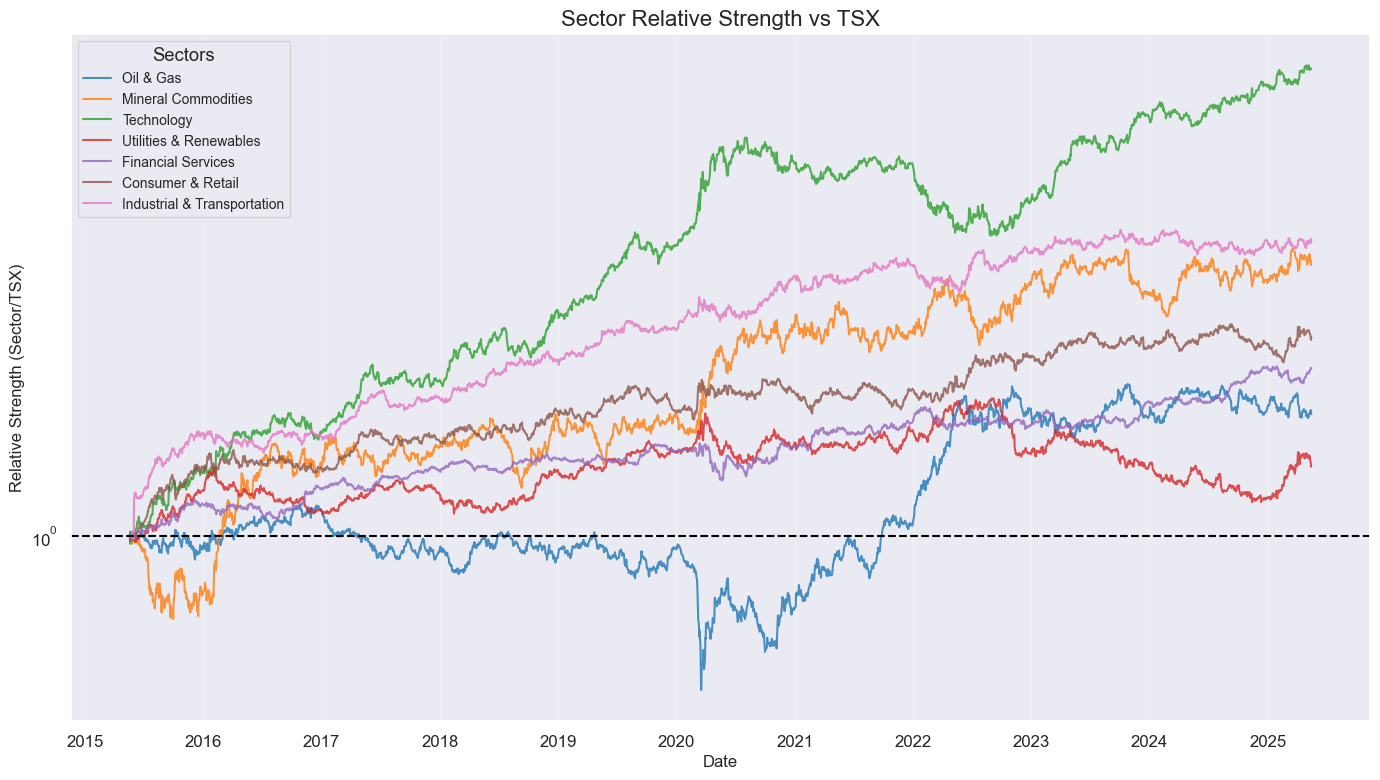

In [44]:
# Plot
plt.figure(figsize=(14, 8))
for sector in relative_strength.columns:
    plt.plot(relative_strength[sector], label=sector, alpha=0.8)

plt.title('Sector Relative Strength vs TSX', fontsize=16)
plt.ylabel('Relative Strength (Sector/TSX)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.axhline(1, color='black', linestyle='--')
plt.legend(title='Sectors', fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In my “Sector Relative Strength vs TSX” plot:

✅ Y-axis = Relative Strength Ratio

It represents the ratio of cumulative returns of a sector to the cumulative returns of the TSX index.

$$
\text{Relative Strength}_{\text{sector}}(t) = \frac{(1 + R_{\text{sector}})^t}{(1 + R_{\text{TSX}})^t}
$$

<Figure size 1400x800 with 0 Axes>

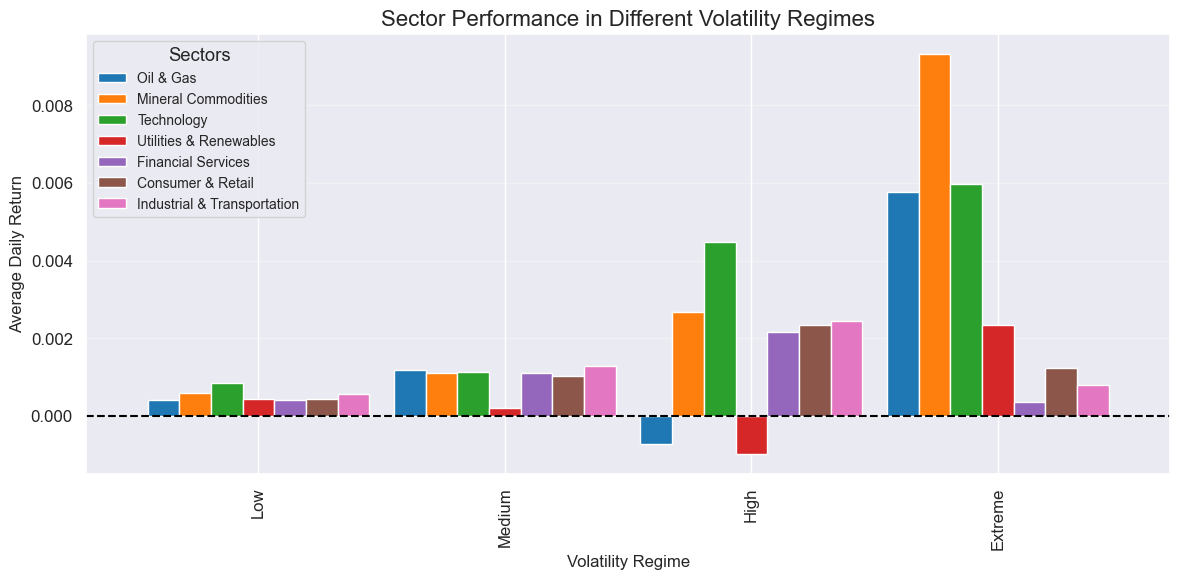

In [45]:
# Calculate market volatility regimes
# Use TSX as a Series for volatility calc
#Identify different volatility regimes and sector performance within them
volatility = tsx_returns.squeeze().rolling(30).std() * np.sqrt(252)

# Categorize into regimes
vol_regimes = pd.cut(volatility, bins=[0, 0.15, 0.25, 0.5, 2],
                     labels=['Low', 'Medium', 'High', 'Extreme'])

# Calculate average sector returns in each regime
regime_returns = pd.DataFrame()
for regime in vol_regimes.cat.categories:
    mask = (vol_regimes == regime)
    regime_returns[regime] = sector_df[mask].mean()

# Plot
plt.figure(figsize=(14, 8))
regime_returns.T.plot(kind='bar', width=0.9)
plt.title('Sector Performance in Different Volatility Regimes', fontsize=16)
plt.ylabel('Average Daily Return', fontsize=12)
plt.xlabel('Volatility Regime', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Sectors', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

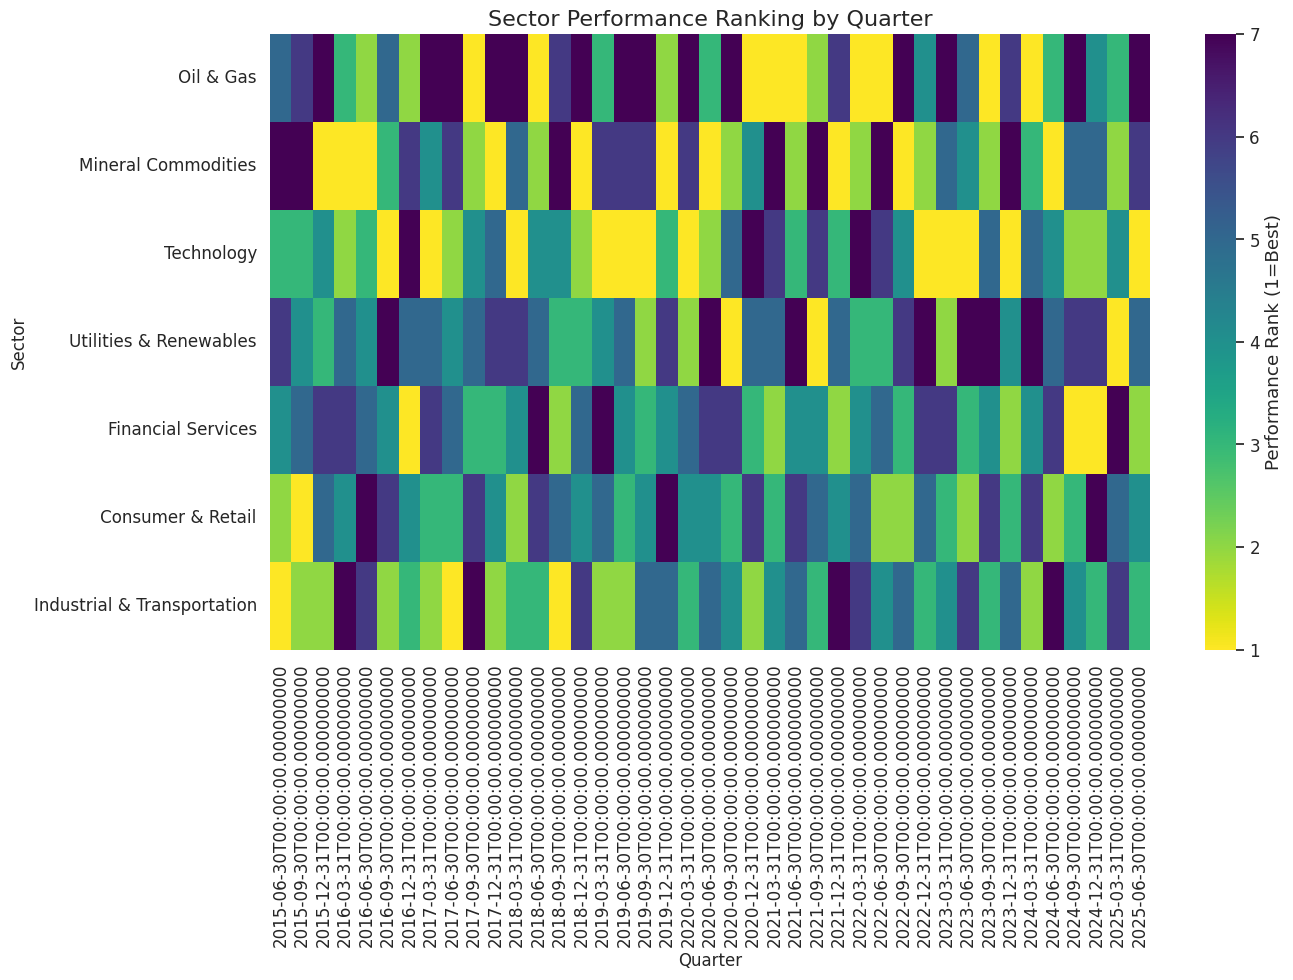

In [79]:
# Calculate quarterly performance
#Show how sector leadership changes over time using a heatmap
quarterly_perf = sector_df.resample('Q').apply(lambda x: (1 + x).prod() - 1)

# Rank sectors each quarter
quarterly_ranks = quarterly_perf.rank(axis=1, ascending=False)

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(quarterly_ranks.T, cmap='viridis_r', annot=False, cbar_kws={'label': 'Performance Rank (1=Best)'})
plt.title('Sector Performance Ranking by Quarter', fontsize=16)
plt.ylabel('Sector', fontsize=12)
plt.xlabel('Quarter', fontsize=12)
plt.tight_layout()
plt.show()

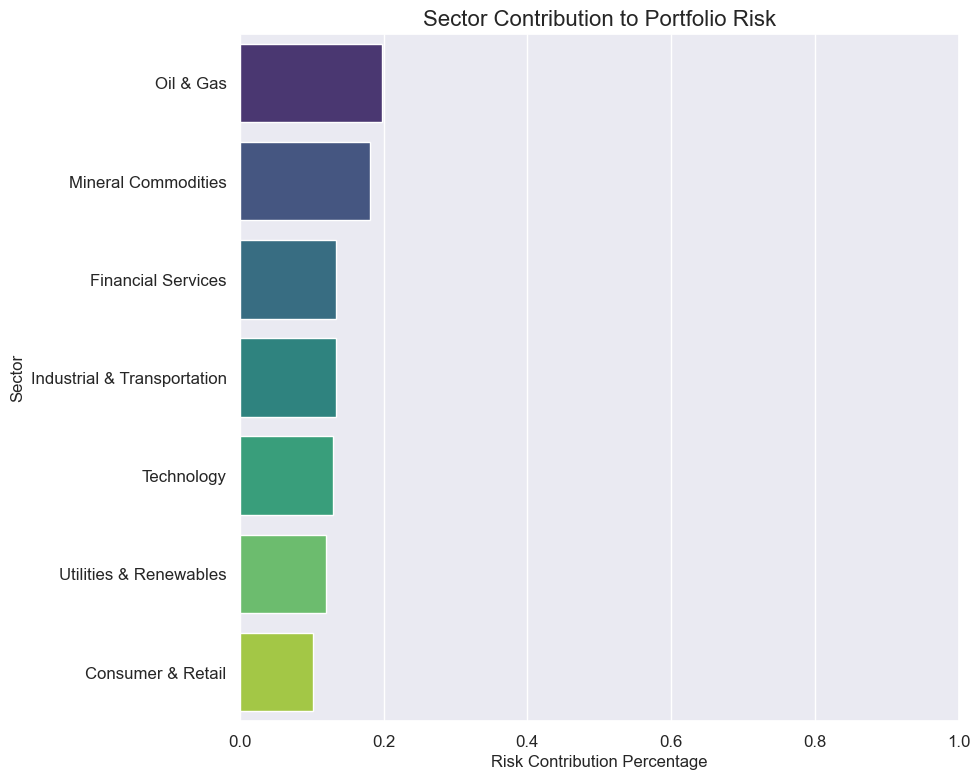

In [46]:
#Show each sector's contribution to portfolio risk
# Calculate covariance matrix
cov_matrix = sector_df.cov() * 252

# Calculate risk contribution
portfolio_weights = np.ones(len(sector_df.columns)) / len(sector_df.columns)  # Equal weight
portfolio_variance = portfolio_weights.T @ cov_matrix @ portfolio_weights
marginal_risk = cov_matrix @ portfolio_weights
risk_contribution = np.multiply(marginal_risk, portfolio_weights) / portfolio_variance

# Plot
plt.figure(figsize=(10, 8))
risk_df = pd.DataFrame({
    'Sector': sector_df.columns,
    'Risk Contribution': risk_contribution
}).sort_values('Risk Contribution', ascending=False)

sns.barplot(x='Risk Contribution', y='Sector', data=risk_df, palette='viridis')
plt.title('Sector Contribution to Portfolio Risk', fontsize=16)
plt.xlabel('Risk Contribution Percentage', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()